In [26]:
# 1. Setup Input Paths
input_dir = Path("/home/ziruz16/predictgbm/data/polar_1d_s2/data_001")

csf_path = input_dir / "csf_pbmap.nii.gz"
gm_path = input_dir / "gm_pbmap.nii.gz"
wm_path = input_dir / "wm_pbmap.nii.gz"
tumor_seg_path = input_dir / "tumor_seg.nii.gz"
recurrence_path = input_dir / "recurrence_preop.nii.gz"

print(f"Input directory: {input_dir}")
print(f"Files found: {csf_path.exists()}, {gm_path.exists()}, {wm_path.exists()}, {tumor_seg_path.exists()}, {recurrence_path.exists()}")

Input directory: /home/ziruz16/predictgbm/data/polar_1d_s2/data_001
Files found: True, True, True, True, True


In [28]:
# 2. Load Data and Compute Phase Field
from solve_phase_field_torch import solve_phase_field_torch
# Load NIfTI files
csf_img = nib.load(csf_path)
gm_img = nib.load(gm_path)
wm_img = nib.load(wm_path)
seg_img = nib.load(tumor_seg_path)
recurrence_img = nib.load(recurrence_path)

# Get data as numpy arrays
Pcsf = csf_img.get_fdata()
Pgm = gm_img.get_fdata()
Pwm = wm_img.get_fdata()
seg = seg_img.get_fdata()
recurrence_seg = recurrence_img.get_fdata()

print(f"Data shape: {Pcsf.shape}")

# Create binary masks
# mask_wt: Whole Tumor (Necrotic(1) + Edema(2) + Enhancing(3))
mask_wt = np.isin(seg, [1, 2, 3]).astype(np.float64)

# mask_tc: Tumor Core (Necrotic(1) + Enhancing(3))
mask_tc = np.isin(seg, [1, 3]).astype(np.float64)

# Recurrence mask (assuming labels 1 and 3 are relevant for recurrence core, or just > 0)
# Usually recurrence analysis focuses on enhancing tumor or core.
# Let's assume recurrence_seg contains labels similar to tumor_seg.
# If it's a binary mask of recurrence, just use > 0.
mask_recurrence = (recurrence_seg > 0).astype(np.float64)

print(f"Whole Tumor volume (voxels): {np.sum(mask_wt)}")
print(f"Tumor Core volume (voxels): {np.sum(mask_tc)}")
print(f"Recurrence volume (voxels): {np.sum(mask_recurrence)}")

# Compute Phase Field
print("Computing phase field...")
phi = solve_phase_field_torch(Pwm, Pgm, Pcsf, numiter=100, epsilon=3)
print("Phase field computation complete.")

Data shape: (240, 240, 155)
Whole Tumor volume (voxels): 127383.0
Tumor Core volume (voxels): 68417.0
Recurrence volume (voxels): 3004.0
Computing phase field...
Phase Field Solver using device: cuda
Phase field computation complete.


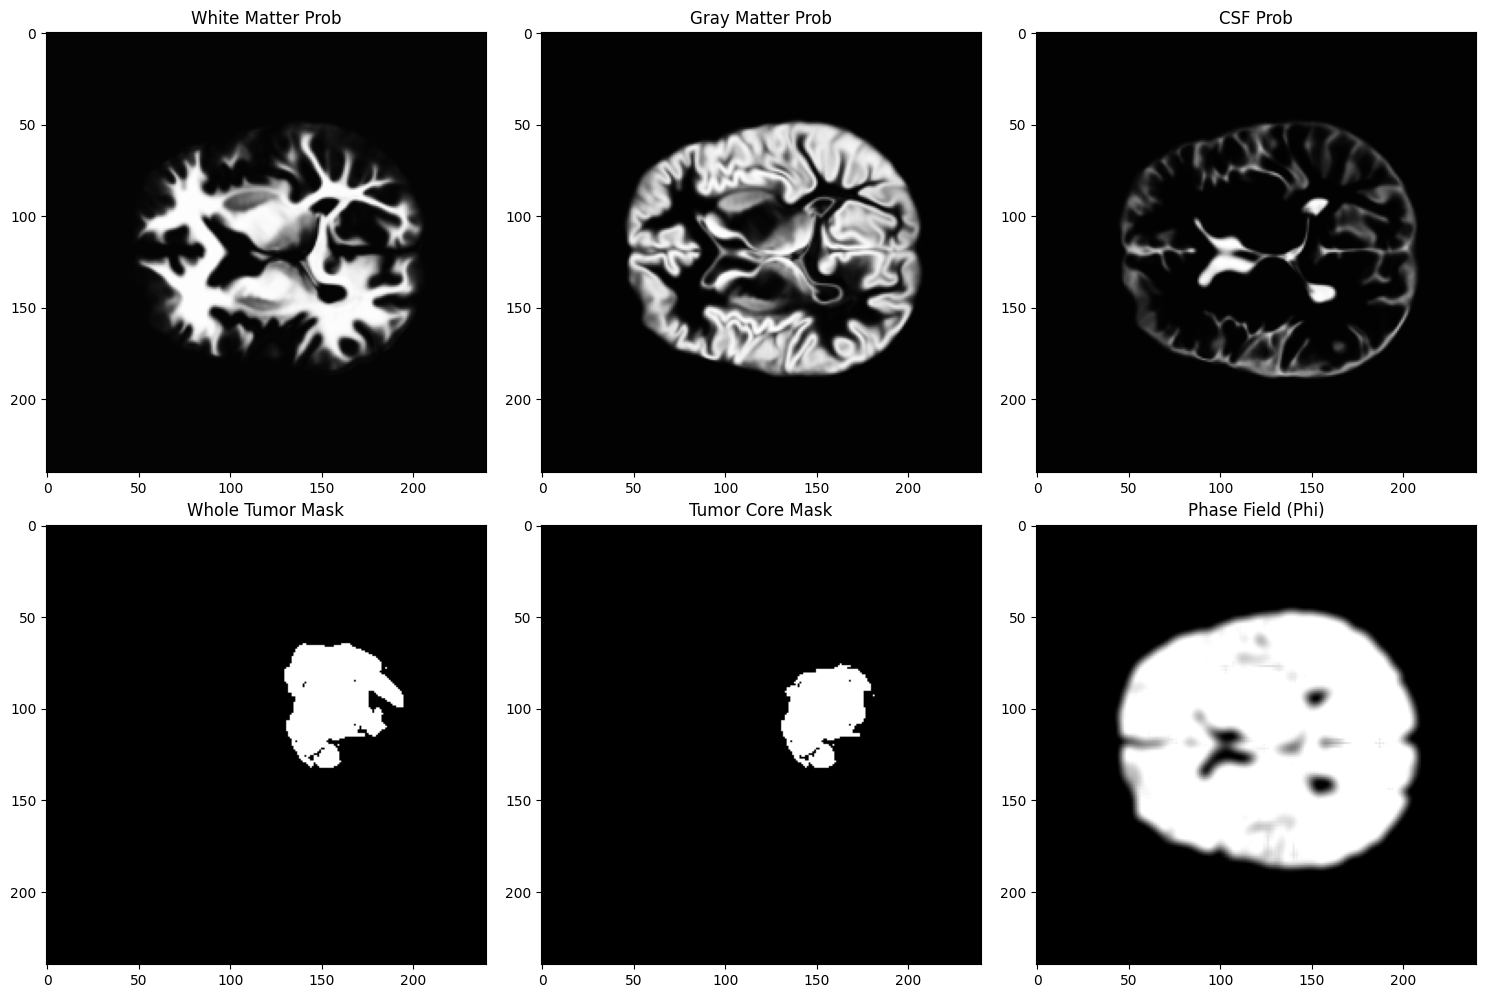

In [29]:
# 3. Visualize Data and Phase Field

# Find the slice with the largest tumor area
z_slice = np.argmax(np.sum(mask_wt, axis=(0, 1)))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(Pwm[:, :, z_slice], cmap='gray')
axes[0, 0].set_title('White Matter Prob')

axes[0, 1].imshow(Pgm[:, :, z_slice], cmap='gray')
axes[0, 1].set_title('Gray Matter Prob')

axes[0, 2].imshow(Pcsf[:, :, z_slice], cmap='gray')
axes[0, 2].set_title('CSF Prob')

axes[1, 0].imshow(mask_wt[:, :, z_slice], cmap='gray')
axes[1, 0].set_title('Whole Tumor Mask')

axes[1, 1].imshow(mask_tc[:, :, z_slice], cmap='gray')
axes[1, 1].set_title('Tumor Core Mask')

axes[1, 2].imshow(phi[:, :, z_slice], cmap='gray')
axes[1, 2].set_title('Phase Field (Phi)')

plt.tight_layout()
plt.show()

In [30]:
# 4. Estimate Characteristic Parameters
from gbmutil import est_char_param, get_char

# Define priors
wt_threshold_prior = 0.35
tc_threshold_prior = 0.60

# Initial condition parameters for 1D simulation in parameter estimation
# These are usually small Gaussian seeds
h_init = 0.5
r_init = 0.1

print("Estimating characteristic parameters...")
# Note: parallel=False to avoid potential issues in notebook environment, set to True if supported
est_params = est_char_param(
    mask_wt, 
    mask_tc, 
    wt_threshold_prior, 
    tc_threshold_prior, 
    h_init, 
    r_init, 
    parallel=False
)

print("\nEstimated Parameters:")
print(f"D (Diffusion): {est_params['D']}")
print(f"rho (Proliferation): {est_params['rho']}")
print(f"L (Char Length): {est_params['L']}")
print(f"T (Char Time): {est_params['T']}")
print(f"Score (Error): {est_params['score']}")
print(f"Estimated Centroid: {est_params['x0']}")

Estimating characteristic parameters...
Estimated tumor centroid at (1-based): [ 97.47838987 156.36080214  78.60942456]
Estimated r_wt_data: 56.8335962906484
Estimated r_tc_data: 44.98631338251479
Grid N=181, dx=1.0000, CFL dt=1.5000e+00
Grid N=181, dx=1.0000, CFL dt=1.5000e+00
Grid N=181, dx=1.0000, CFL dt=1.5000e+00
Grid N=181, dx=1.0000, CFL dt=1.5000e+00
Grid N=181, dx=1.0000, CFL dt=1.5000e+00
Grid N=181, dx=1.0000, CFL dt=1.5000e+00
Grid N=181, dx=1.0000, CFL dt=1.5000e+00
Grid N=181, dx=1.0000, CFL dt=1.5000e+00
Grid N=181, dx=1.0000, CFL dt=1.5000e+00
Grid N=181, dx=1.0000, CFL dt=1.5000e+00
Grid N=181, dx=1.0000, CFL dt=7.5000e-01
Grid N=181, dx=1.0000, CFL dt=7.5000e-01
Grid N=181, dx=1.0000, CFL dt=7.5000e-01
Grid N=181, dx=1.0000, CFL dt=7.5000e-01
Grid N=181, dx=1.0000, CFL dt=7.5000e-01
Grid N=181, dx=1.0000, CFL dt=7.5000e-01


Grid N=181, dx=1.0000, CFL dt=7.5000e-01
Grid N=181, dx=1.0000, CFL dt=7.5000e-01
Grid N=181, dx=1.0000, CFL dt=7.5000e-01
Grid N=181, dx=1.0000, CFL dt=7.5000e-01
Grid N=181, dx=1.0000, CFL dt=5.0000e-01
Grid N=181, dx=1.0000, CFL dt=5.0000e-01
Grid N=181, dx=1.0000, CFL dt=5.0000e-01
Grid N=181, dx=1.0000, CFL dt=5.0000e-01
Grid N=181, dx=1.0000, CFL dt=5.0000e-01
Grid N=181, dx=1.0000, CFL dt=5.0000e-01
Grid N=181, dx=1.0000, CFL dt=5.0000e-01
Grid N=181, dx=1.0000, CFL dt=5.0000e-01
Grid N=181, dx=1.0000, CFL dt=5.0000e-01
Grid N=181, dx=1.0000, CFL dt=5.0000e-01
Grid N=181, dx=1.0000, CFL dt=3.7500e-01
Grid N=181, dx=1.0000, CFL dt=3.7500e-01
Grid N=181, dx=1.0000, CFL dt=3.7500e-01
Grid N=181, dx=1.0000, CFL dt=3.7500e-01
Grid N=181, dx=1.0000, CFL dt=3.7500e-01
Grid N=181, dx=1.0000, CFL dt=3.7500e-01
Grid N=181, dx=1.0000, CFL dt=3.7500e-01
Grid N=181, dx=1.0000, CFL dt=3.7500e-01
Grid N=181, dx=1.0000, CFL dt=3.7500e-01
Grid N=181, dx=1.0000, CFL dt=3.7500e-01
Grid N=181, dx=1

In [31]:
# 5. Run Fisher-KPP Simulation
from solve_fisher_kpp_torch import solve_fisher_kpp_torch
import torch

# Get parameters
D = est_params['D']
rho = est_params['rho']
T = est_params['T']
x0 = est_params['x0'] # 1-based index from est_char_param

# Adjust centroid to 0-based index for python
center = x0 - 1.0 

# Create initial condition u0 (Gaussian at estimated centroid)
sigma = 3.0
x = np.arange(Pwm.shape[0])
y = np.arange(Pwm.shape[1])
z = np.arange(Pwm.shape[2])
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')

dist_sq = (xx - center[0])**2 + (yy - center[1])**2 + (zz - center[2])**2
u0 = h_init * np.exp(-r_init * dist_sq)

# Solve Fisher-KPP
dw = D
factor = 10.0 # Dw / Dg ratio

print(f"Running simulation with Dw={dw}, rho={rho}, T={T}...")
print(f"CUDA Available: {torch.cuda.is_available()}")

Nt = 2 

# Use the PyTorch version
u_all, t_all = solve_fisher_kpp_torch(
    Pwm, 
    Pgm, 
    dw=dw, 
    factor=factor, 
    phi=phi, 
    rho=rho, 
    tfinal=T, 
    u0=u0, 
    Nt=Nt
)

u_final = u_all[..., -1]
print(f"Simulation complete. Max tumor density: {np.max(u_final)}")

Running simulation with Dw=0.30000000000000004, rho=0.01, T=1040.6728592598156...
CUDA Available: True
Using device: cuda
Starting simulation (PyTorch). tfinal=1040.6728592598156, dt=5.4997e-01
Simulation complete. Max tumor density: 1.0


In [32]:
# 6. Save Prediction Results

output_dir = Path("output_prediction")
output_dir.mkdir(exist_ok=True)

output_path = output_dir / "prediction.nii.gz"

# Create NIfTI image using the affine from the input
pred_img = nib.Nifti1Image(u_final, csf_img.affine, csf_img.header)

nib.save(pred_img, output_path)
print(f"Prediction saved to {output_path}")

Prediction saved to output_prediction/prediction.nii.gz


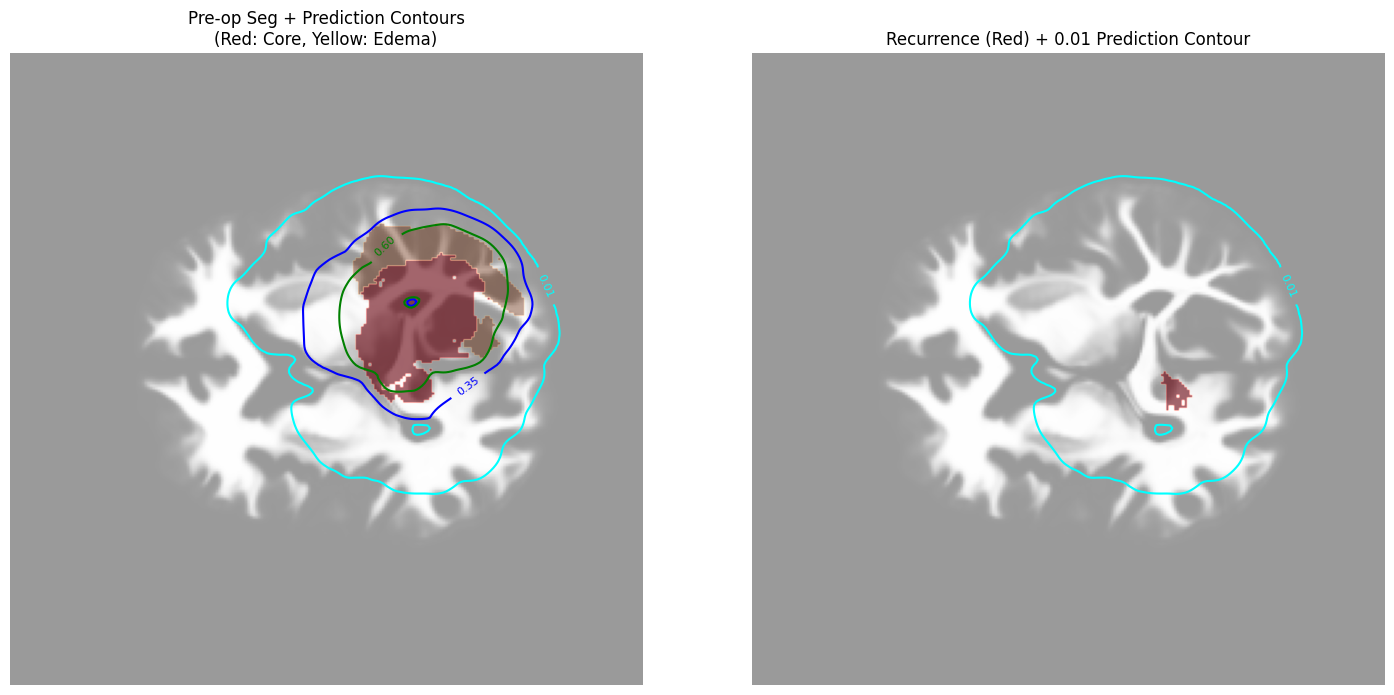

In [33]:
# 7. Visualize Prediction Contours

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# --- Left Panel: Pre-op Segmentation + Prediction Contours ---
# Background: Pwm for context
ax[0].imshow(Pwm[:, :, z_slice], cmap='gray', alpha=0.4)

# Color Edema (Label 2)
mask_edema = (seg == 2).astype(float)
# Color Necrotic + Active (Labels 1 + 3) -> mask_tc
mask_core = mask_tc

# Overlay Edema (Yellowish)
ax[0].imshow(mask_edema[:, :, z_slice], cmap='YlOrBr', alpha=0.4 * mask_edema[:, :, z_slice])
# Overlay Core (Reddish)
ax[0].imshow(mask_core[:, :, z_slice], cmap='Reds', alpha=0.6 * mask_core[:, :, z_slice])

# Contours: 0.01, 0.35, 0.6
levels = [0.01, 0.35, 0.6]
colors = ['cyan', 'blue', 'green']
contours = ax[0].contour(u_final[:, :, z_slice], levels=levels, colors=colors, linewidths=1.5)
ax[0].clabel(contours, inline=True, fontsize=8, fmt='%.2f')

ax[0].set_title('Pre-op Seg + Prediction Contours\n(Red: Core, Yellow: Edema)')
ax[0].axis('off')

# --- Right Panel: Recurrence + 0.01 Contour ---
# Background: Recurrence Segmentation
# Let's show recurrence in Red
ax[1].imshow(Pwm[:, :, z_slice], cmap='gray', alpha=0.4)
ax[1].imshow(mask_recurrence[:, :, z_slice], cmap='Reds', alpha=0.6 * mask_recurrence[:, :, z_slice])

# Overlay 0.01 Contour
contour_rec = ax[1].contour(u_final[:, :, z_slice], levels=[0.01], colors=['cyan'], linewidths=1.5)
ax[1].clabel(contour_rec, inline=True, fontsize=8, fmt='%.2f')

ax[1].set_title('Recurrence (Red) + 0.01 Prediction Contour')
ax[1].axis('off')

plt.tight_layout()
plt.show()

/home/ziruz16/.conda/envs/torch2/lib/python3.11/site-packages/brainles_preprocessing/registration/__init__.py:18: UserWarning: itk-elastix package not found. If you want to use it, please install it using 'pip install brainles_preprocessing[itk-elastix]'
  warnings.warn(
/home/ziruz16/.conda/envs/torch2/lib/python3.11/site-packages/brainles_preprocessing/registration/__init__.py:25: UserWarning: picsl_greedy  package not found. If you want to use it, please install it using 'pip install brainles_preprocessing[picsl_greedy]'
  warnings.warn(


Running evaluation using PredictGBM...

Evaluation Results:
{
  "recurrence_coverage_standard": 1.0,
  "recurrence_coverage_standard_all": 1.0,
  "recurrence_coverage_model": 0.9707057256990679,
  "recurrence_coverage_model_all": 0.9707057256990679
}


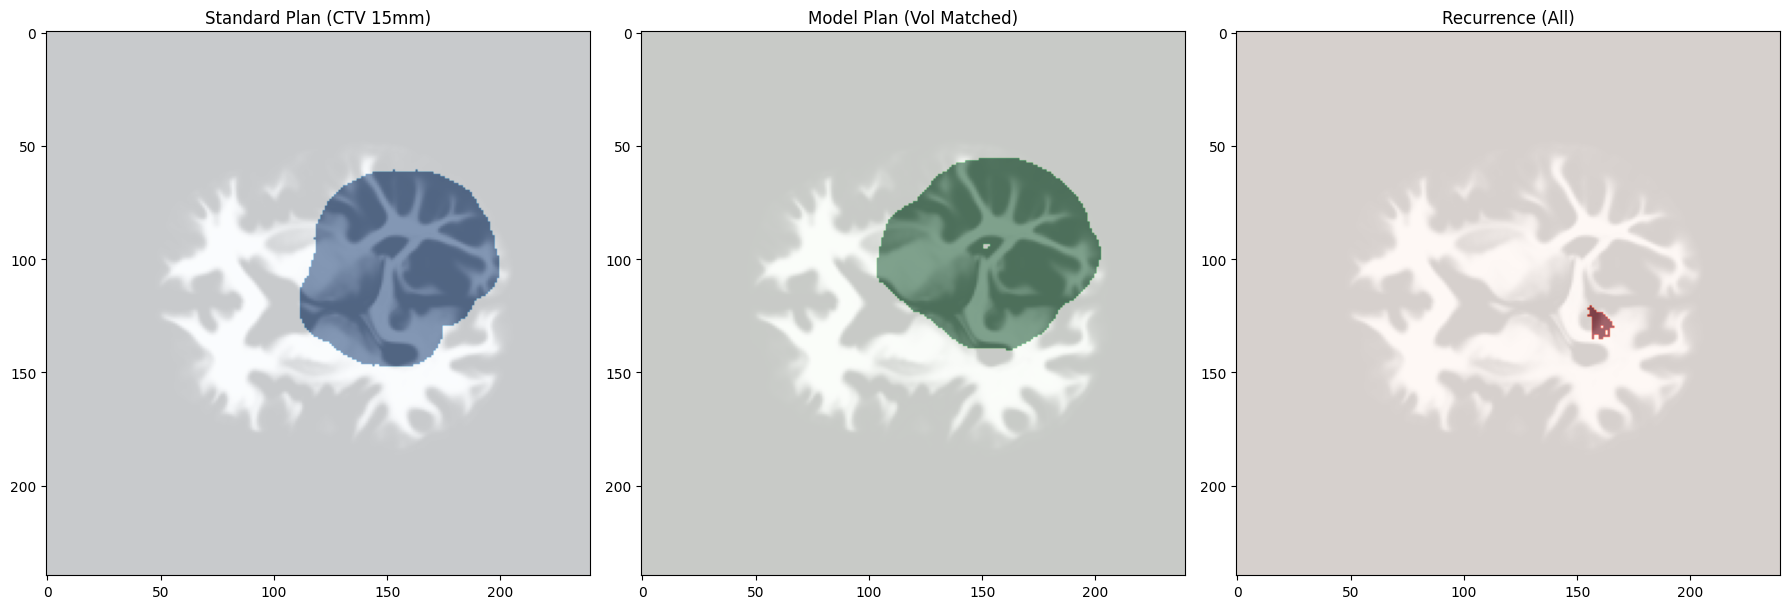

In [36]:
# 8. Evaluation using PredictGBM
import sys
import json
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Ensure PredictGBM is in path
predict_gbm_path = "/home/ziruz16/predictgbm/PredictGBM"
if predict_gbm_path not in sys.path:
    sys.path.append(predict_gbm_path)

from predict_gbm.evaluation.evaluate import evaluate_tumor_model

# We need a brain mask file for evaluation
# Let's create one from the probability maps
brain_mask_data = (Pwm + Pgm + Pcsf) > 0.1
brain_mask_img = nib.Nifti1Image(brain_mask_data.astype(np.uint8), csf_img.affine, csf_img.header)
brain_mask_path = output_dir / "brain_mask.nii.gz"
nib.save(brain_mask_img, brain_mask_path)

print("Running evaluation using PredictGBM...")

# output_path was defined in the previous cell (prediction.nii.gz)
# We use csf_path as t1c_file proxy to provide affine, as evaluate.py requires it

results, standard_plan_nii, model_plan_nii = evaluate_tumor_model(
    tumorseg_file=tumor_seg_path,
    recurrence_file=recurrence_path,
    pred_file=output_path,
    brain_mask_file=brain_mask_path,
    t1c_file=csf_path, # Proxy for affine
    ctv_margin=15
)

print("\nEvaluation Results:")
print(json.dumps(results, indent=2))

# Visualize Plans
standard_plan = standard_plan_nii.get_fdata()
model_plan = model_plan_nii.get_fdata()

# Recurrence mask for viz
rec_seg_all = np.isin(recurrence_seg, [1, 2, 3])

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(Pwm[:, :, z_slice], cmap='gray', alpha=0.4)
ax[0].imshow(standard_plan[:, :, z_slice], cmap='Blues', alpha=0.5)
ax[0].set_title('Standard Plan (CTV 15mm)')

ax[1].imshow(Pwm[:, :, z_slice], cmap='gray', alpha=0.4)
ax[1].imshow(model_plan[:, :, z_slice], cmap='Greens', alpha=0.5)
ax[1].set_title(f'Model Plan (Vol Matched)')

ax[2].imshow(Pwm[:, :, z_slice], cmap='gray', alpha=0.4)
ax[2].imshow(rec_seg_all[:, :, z_slice], cmap='Reds', alpha=0.6)
ax[2].set_title('Recurrence (All)')

plt.tight_layout()
plt.show()